# Text classification and sentiment analysis: Yelp Reviews

Once text data has been converted into numerical features using the natural language processing techniques discussed in the previous sections, text classification works just like any other classification task.

In this notebook, we will apply these preprocessing technique to Yelp business reviews to classify them by review scores and sentiment polarity.

## Imports

In [1]:
%matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from scipy import sparse
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob, Word

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import joblib

import lightgbm as lgb

import json
from time import clock, time

In [2]:
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
np.random.seed(42)

## Yelp Challenge: business reviews dataset

Finally, we apply sentiment analysis to the significantly larger Yelp business review dataset with five outcome classes. 

The data consists of several files with information on the business, the user, the review and other aspects that Yelp provides to encourage data science innovation. 

We will use around six million reviews produced over the 2010-2018 period. In addition to the text features resulting from the review texts, we will also use other information submitted with the review about the user. 

The [Yelp](https://www.yelp.com/dataset) dataset covers a subset of Yelp's businesses, reviews, and user data. 

You can download the data come in json format after accepting the license. It contains 3.6GB (compressed) and around 9GB (uncompressed) of text data. 

After download, extract the user.json and reviews.json files into to `data/yelp/json`

### Set up data directories

We parse the json files and store the result in parquet format in our cental data directory so we can reuse the cleaned data. You can remove the large json files after parsing.

In [3]:
data_dir = Path('../data')

In [4]:
yelp_dir = Path('data', 'yelp')
parquet_dir = data_dir / 'yelp'
if not parquet_dir.exists():
    parquet_dir.mkdir(exist_ok=True)
text_features_dir = yelp_dir / 'text_features'
if not text_features_dir.exists():
    text_features_dir.mkdir(exist_ok=True)    

### Parse json and store as parquet files

In [4]:
for file in ['review', 'user']:
    print(file)
    json_file = yelp_dir / 'json' / f'{file}.json'
    parquet_file = parquet_dir / f'{file}.parquet'

    data = json_file.read_text(encoding='utf-8')
    json_data = '[' + ','.join([l.strip()
                                for l in data.split('\n') if l.strip()]) + ']\n'
    data = json.loads(json_data)
    df = json_normalize(data)
    if file == 'review':
        df.date = pd.to_datetime(df.date)
        latest = df.date.max()
        df['year'] = df.date.dt.year
        df['month'] = df.date.dt.month
        df = df.drop(['date', 'business_id', 'review_id'], axis=1)
    if file == 'user':
        df.yelping_since = pd.to_datetime(df.yelping_since)
        df = (df.assign(member_yrs=lambda x: (latest - x.yelping_since)
                        .dt.days.div(365).astype(int))
              .drop(['elite', 'friends', 'name', 'yelping_since'], axis=1))
    df.dropna(how='all', axis=1).to_parquet(parquet_file)


review
user


In [5]:
user = pd.read_parquet(parquet_dir / 'user.parquet')
user.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637138 entries, 0 to 1637137
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   average_stars       1637138 non-null  float64
 1   compliment_cool     1637138 non-null  int64  
 2   compliment_cute     1637138 non-null  int64  
 3   compliment_funny    1637138 non-null  int64  
 4   compliment_hot      1637138 non-null  int64  
 5   compliment_list     1637138 non-null  int64  
 6   compliment_more     1637138 non-null  int64  
 7   compliment_note     1637138 non-null  int64  
 8   compliment_photos   1637138 non-null  int64  
 9   compliment_plain    1637138 non-null  int64  
 10  compliment_profile  1637138 non-null  int64  
 11  compliment_writer   1637138 non-null  int64  
 12  cool                1637138 non-null  int64  
 13  fans                1637138 non-null  int64  
 14  funny               1637138 non-null  int64  
 15  review_count   

In [6]:
user.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count,useful,user_id,member_yrs
0,4.03,1,0,1,2,0,0,1,0,1,0,2,25,5,17,95,84,l6BmjZMeQD3rDxWUbiAiow,5
1,3.63,1,0,1,1,0,0,0,0,0,0,0,16,4,22,33,48,4XChL029mKr5hydo79Ljxg,5
2,3.71,0,0,0,0,0,0,1,0,0,0,0,10,0,8,16,28,bc8C_eETBWL0olvFSJJd0w,5
3,4.85,0,0,0,1,0,0,0,0,2,0,1,14,5,4,17,30,dD0gZpBctWGdWo9WlGuhlA,4
4,4.08,80,0,80,28,1,1,16,5,57,0,25,665,39,279,361,1114,MM4RJAeH6yuaN8oZDSt0RA,5


In [7]:
review = pd.read_parquet(parquet_dir / 'review.parquet')
review.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   cool     6685900 non-null  int64  
 1   funny    6685900 non-null  int64  
 2   stars    6685900 non-null  float64
 3   text     6685900 non-null  object 
 4   useful   6685900 non-null  int64  
 5   user_id  6685900 non-null  object 
 6   year     6685900 non-null  int64  
 7   month    6685900 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 408.1+ MB


### Merge review and user files

In [8]:
combined = (review
            .merge(user, on='user_id', how='left', suffixes=['', '_user'])
            .drop('user_id', axis=1))
combined = combined[combined.stars > 0]
combined.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685900 entries, 0 to 6685899
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   cool                6685900 non-null  int64  
 1   funny               6685900 non-null  int64  
 2   stars               6685900 non-null  float64
 3   text                6685900 non-null  object 
 4   useful              6685900 non-null  int64  
 5   year                6685900 non-null  int64  
 6   month               6685900 non-null  int64  
 7   average_stars       6685900 non-null  float64
 8   compliment_cool     6685900 non-null  int64  
 9   compliment_cute     6685900 non-null  int64  
 10  compliment_funny    6685900 non-null  int64  
 11  compliment_hot      6685900 non-null  int64  
 12  compliment_list     6685900 non-null  int64  
 13  compliment_more     6685900 non-null  int64  
 14  compliment_note     6685900 non-null  int64  
 15  compliment_phot

In [9]:
combined.to_parquet(parquet_dir / 'combined.parquet')

In [5]:
combined = pd.read_parquet(parquet_dir / 'combined.parquet')

### Explore data

The following figure shows the number of reviews and the average number of stars per year.

#### Reviews & Stars by Year

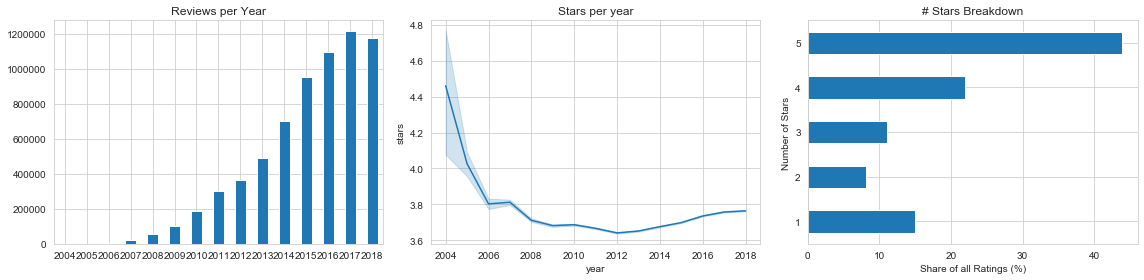

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
combined.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0], rot=0);
sns.lineplot(x='year', y='stars', data=combined, ax=axes[1])
axes[1].set_title('Stars per year')

stars_dist = combined.stars.value_counts(normalize=True).sort_index().mul(100)
stars_dist.index = stars_dist.index.astype(int)
stars_dist.plot.barh(title='# Stars Breakdown', ax=axes[2])
axes[2].set_xlabel('Share of all Ratings (%)')
axes[2].set_ylabel('Number of Stars');

fig.tight_layout()
fig.savefig('figures/yelp_stats');

#### Years of Membership Breakdown

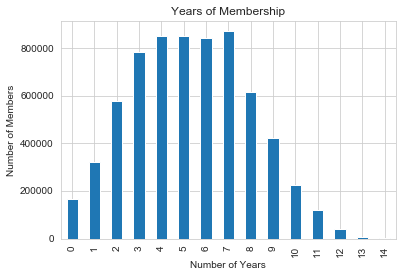

In [15]:
ax = combined.member_yrs.value_counts().sort_index().plot.bar(title='Years of Membership')
ax.set_xlabel('Number of Years')
ax.set_ylabel('Number of Members');

### Create train-test split

In [7]:
train = combined[combined.year < 2018].sample(frac=.1)
test = combined[combined.year == 2018]

In [8]:
train.to_parquet(parquet_dir / 'train.parquet')
test.to_parquet(parquet_dir / 'test.parquet')

#### Reload stored data

In [7]:
train = pd.read_parquet(parquet_dir / 'train.parquet')
test = pd.read_parquet(parquet_dir / 'test.parquet')

## Create Yelp review document-term matrix

In [9]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
train_dtm = vectorizer.fit_transform(train.text)
train_dtm

<550824x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 25059161 stored elements in Compressed Sparse Row format>

In [10]:
sparse.save_npz(text_features_dir / 'train_dtm', train_dtm)

In [12]:
test_dtm = vectorizer.transform(test.text)
sparse.save_npz(text_features_dir / 'test_dtm', test_dtm)

### Reload stored data

In [8]:
train_dtm = sparse.load_npz(text_features_dir / 'train_dtm.npz')
test_dtm = sparse.load_npz(text_features_dir / 'test_dtm.npz')

## Combine non-text features with the document-term matrix

The dataset contains various numerical features. The vectorizers produce [scipy.sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html). To combine the vectorized text data with other features, we need to first convert these to sparse matrices as well; many sklearn objects and other libraries like lightgbm can handle these very memory-efficient data structures. Converting the sparse matrix to a dense numpy array risks memory overflow.

Most variables are categorical so we use one-hot encoding since we have a fairly large dataset to accommodate the increase in features.

We convert the encoded numerical features and combine them with the document-term matrix:

### One-hot-encoding 

In [22]:
df = pd.concat([train.drop(['text', 'stars'], axis=1).assign(source='train'),
                test.drop(['text', 'stars'], axis=1).assign(source='test')])

In [23]:
uniques = df.nunique()
binned = pd.concat([(df.loc[:, uniques[uniques > 20].index]
                     .apply(pd.qcut, q=10, labels=False, duplicates='drop')),
                    df.loc[:, uniques[uniques <= 20].index]], axis=1)
binned.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728486 entries, 964767 to 6685899
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   cool                1728486 non-null  int64 
 1   funny               1728486 non-null  int64 
 2   useful              1728486 non-null  int64 
 3   average_stars       1728486 non-null  int64 
 4   compliment_cool     1728486 non-null  int64 
 5   compliment_cute     1728486 non-null  int64 
 6   compliment_funny    1728486 non-null  int64 
 7   compliment_hot      1728486 non-null  int64 
 8   compliment_list     1728486 non-null  int64 
 9   compliment_more     1728486 non-null  int64 
 10  compliment_note     1728486 non-null  int64 
 11  compliment_photos   1728486 non-null  int64 
 12  compliment_plain    1728486 non-null  int64 
 13  compliment_profile  1728486 non-null  int64 
 14  compliment_writer   1728486 non-null  int64 
 15  cool_user           1728486

In [24]:
dummies = pd.get_dummies(binned, columns=binned.columns.drop('source'), drop_first=True)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728486 entries, 964767 to 6685899
Columns: 101 entries, source to member_yrs_14
dtypes: object(1), uint8(100)
memory usage: 191.2+ MB


In [25]:
train_dummies = dummies[dummies.source=='train'].drop('source', axis=1)
train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550824 entries, 964767 to 3426680
Data columns (total 100 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   cool_1               550824 non-null  uint8
 1   funny_1              550824 non-null  uint8
 2   useful_1             550824 non-null  uint8
 3   useful_2             550824 non-null  uint8
 4   average_stars_1      550824 non-null  uint8
 5   average_stars_2      550824 non-null  uint8
 6   average_stars_3      550824 non-null  uint8
 7   average_stars_4      550824 non-null  uint8
 8   average_stars_5      550824 non-null  uint8
 9   average_stars_6      550824 non-null  uint8
 10  average_stars_7      550824 non-null  uint8
 11  average_stars_8      550824 non-null  uint8
 12  average_stars_9      550824 non-null  uint8
 13  compliment_cool_1    550824 non-null  uint8
 14  compliment_cool_2    550824 non-null  uint8
 15  compliment_funny_1   550824 non-null  uint8


### Train set

In [26]:
# Cast other feature columns to float and convert to a sparse matrix.
train_numeric = sparse.csr_matrix(train_dummies.astype(np.int8))
train_numeric.shape

(550824, 100)

In [27]:
# Combine sparse matrices.
train_dtm_numeric = sparse.hstack((train_dtm, train_numeric))
train_dtm_numeric.shape

(550824, 10100)

In [28]:
sparse.save_npz(text_features_dir / 'train_dtm_numeric', train_dtm_numeric)

### Repeat for test set

In [29]:
test_dummies = dummies[dummies.source=='test'].drop('source', axis=1)
test_numeric = sparse.csr_matrix(test_dummies.astype(np.int8))
test_dtm_numeric = sparse.hstack((test_dtm, test_numeric))
test_dtm_numeric.shape

(1177662, 10100)

In [30]:
sparse.save_npz(text_features_dir / 'test_dtm_numeric', test_dtm_numeric)

### Reload stored data

In [9]:
train_dtm_numeric = sparse.load_npz(text_features_dir / 'train_dtm_numeric.npz')
test_dtm_numeric = sparse.load_npz(text_features_dir / 'test_dtm_numeric.npz')

## Benchmark Accuracy

In [10]:
accuracy, runtime = {}, {}
predictions = test[['stars']].copy()

Using the most frequent number of stars (=5) to predict the test set achieve an accuracy close to 51%:

In [11]:
predictions['benchmark'] = train.stars.mode().iloc[0]

In [12]:
accuracy['benchmark'] = accuracy_score(predictions.stars, predictions.benchmark)

In [13]:
accuracy['benchmark']

0.5096963305260762

## Model Evaluation Helper

In [14]:
def evaluate_model(model, X_train, X_test, name, store=False):
    start = time()
    model.fit(X_train, train.stars)
    runtime[name] = time() - start
    predictions[name] = model.predict(X_test)
    accuracy[result] = accuracy_score(test.stars, predictions[result])
    if store:
        joblib.dump(model, f'results/{result}.joblib')

## Multiclass Naive Bayes

In [15]:
nb = MultinomialNB()

### Text Features

Next, we train a Naive Bayes classifier using a document-term matrix produced by the CountVectorizer with default settings.

In [16]:
result = 'nb_text'

In [17]:
evaluate_model(nb, train_dtm, test_dtm, result, store=False)

#### Accuracy

The prediction produces 64.4% accuracy on the test set, a 24.2% improvement over the benchmark:

In [18]:
accuracy[result]

0.6439971740618275

#### Confusion Matrix

In [19]:
stars = index=list(range(1,6))
pd.DataFrame(confusion_matrix(test.stars, predictions[result]), 
             columns=stars,
             index=stars)

,1,2,3,4,5
1,153421,37074,7759,2960,3968
2,25089,29791,18833,4687,2935
3,11817,17527,39640,24187,6739
4,7827,5791,22653,110243,44471
5,29093,3561,6717,135563,425316


### Text & Numeric Features

In [20]:
result = 'nb_combined'

In [21]:
evaluate_model(nb, train_dtm_numeric, test_dtm_numeric, result, store=False)

#### Accuracy

In [22]:
accuracy[result]

0.6705778058560096

## Multinomial Logistic Regression

Logistic regression also provides a multinomial training option that is faster and more accurate than the one-vs-all implementation. We use the lbfgs solver (see sklearn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for details).

In [34]:
Cs = np.logspace(-5, 5, 11)

### Text Features

In [ ]:
accuracy = {}
for C in Cs:
    result=C
    model = LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs')
    evaluate_model(model, train_dtm, test_dtm, result, store=True)
    print(f'{C}: {runtime[C]:.2f}s | {accuracy[result]:.2%}', flush=True)

In [ ]:
accuracy.to_csv('results/logreg_text.csv')

### Combined Features

In [ ]:
accuracy = {}
for C in Cs:
    start = time()
    result=str(C)
    model = LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs')
    evaluate_model(model, train_dtm_numeric, test_dtm_numeric, result, store=True)
    print(f'{C}: {time()-start:.2f}s | {accuracy[result]:.2%}', flush=True)

In [ ]:
accuracy.to_csv('results/logreg_text.csv')

In [53]:
accuracy = pd.Series({'Naive Bayes': 0.6705778058560096,
           'Benchmark': 0.5096963305260762,
           'Logistic Regression': 0.740659,
           'Gradient Boosting': 0.7360524496842048})

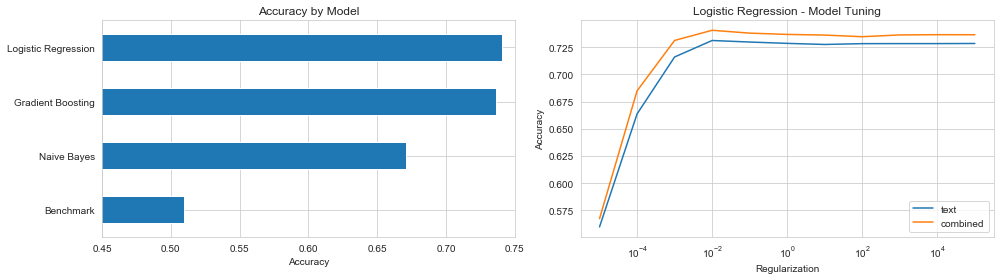

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
accuracy.sort_values().plot.barh(ax=axes[0], xlim=(.45, .75), title='Accuracy by Model')
acc_text = pd.read_csv('results/logreg_text.csv', index_col=0, squeeze=True)
acc_comb = pd.read_csv('results/logreg_combined.csv', index_col=0, squeeze=True)
acc_text.to_frame('text').join(acc_comb.to_frame('combined')).plot(logx=True, ax=axes[1], title='Logistic Regression - Model Tuning')
axes[1].set_xlabel('Regularization')
axes[1].set_ylabel('Accuracy')
axes[0].set_xlabel('Accuracy')
fig.tight_layout()
fig.savefig('figures/yelp_accuracy');

## Gradient Boosting

For illustration, we also train a lightgbm Gradient Boosting tree ensemble with default settings and multiclass objective.

In [32]:
lgb_train = lgb.Dataset(data=train_dtm_numeric.tocsr().astype(np.float32), 
                        label=train.stars.sub(1), 
                        categorical_feature=list(range(train_dtm_numeric.shape[1])))

In [33]:
lgb_test = lgb.Dataset(data=test_dtm_numeric.tocsr().astype(np.float32), 
                       label=test.stars.sub(1), 
                       reference=lgb_train)

In [34]:
param = {'objective':'multiclass', 'num_class': 5}

In [ ]:
booster = lgb.train(params=param,
                    train_set=lgb_train,
                    num_boost_round=500,
                    early_stopping_rounds=20,
                    valid_sets=[lgb_train, lgb_test],
                    verbose=50)

In [39]:
booster.save_model('results/lgb_model.txt');

In [40]:
y_pred_class = booster.predict(test_dtm_numeric.astype(float))

The basic settings did not improve over the multinomial logistic regression, but further parameter tuning remains an unused option.

In [41]:
accuracy_score(test.stars, y_pred_class.argmax(1) + 1)

0.7360524496842048

In [42]:
fi = booster.feature_importance(importance_type='gain')
pd.Series(fi).div(fi.sum()).sort_values(ascending=False).head()

10012    0.070587
3838     0.036915
10011    0.032073
9885     0.028413
3663     0.026046
dtype: float64

## Textblob for Sentiment Analysis

In [63]:
sample_review = train.text.sample(1).iloc[0]
print(sample_review)

Quite a bit for the meh food. I've never had egg flower soup that had a gel consistency. Some of the meal was really hot and some just warm. 
 The service was not very good. She was friendly but it seemed like she was unsure of herself. I did tip but not the percentage I normally would. I left 10% and normally I would leave at least 20.
Won't be back


In [60]:
# Polarity ranges from -1 (most negative) to 1 (most positive).
TextBlob(sample_review).sentiment.polarity

0.095

In [61]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [64]:
train['sentiment'] = train.text.apply(detect_sentiment)

In [65]:
sample_reviews = train[['stars', 'text']].sample(100000)

In [66]:
# Create a new DataFrame column for sentiment (Warning: SLOW!).
sample_reviews['sentiment'] = sample_reviews.text.apply(detect_sentiment)

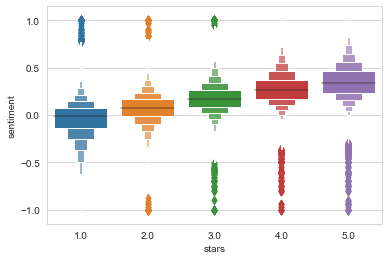

In [68]:
# Box plot of sentiment grouped by stars
sns.boxenplot(x='stars', y='sentiment', data=train);

In [69]:
# Widen the column display.
pd.set_option('max_colwidth', 500)

In [70]:
# Reviews with most negative sentiment
train[train.sentiment == -1].text.head()

6110660                                                                                                   Horrible company. Don't support stores looking to trap you into a contract. Go anywhere else.
4139184                      This location is the worst. The employees never quite seem to know what they're doing and it always smells like sewer inside. I recommend finding another location nearby.
2702386                                                                                                      I've died and gone to HELL! This store is wrong...SO wrong!!! Tack-O-Rama at its finest!!!
241851     if aaa calls this tow truck to help u , run cancel if u do use there services it will be your worst nightmare!!!the worst experience ever , do not trust them with your car nor your life!!!
5237493                                         This place is horrible. The manager, "Emily", is one of the rudest people I have ever come across. I specifically will not be returning because of her.


In [ ]:
# Negative sentiment in a 5-star review
train[(train.stars == 5) & (combined.sentiment < -0.3)].head(1)

In [71]:
# Positive sentiment in a 1-star review
train.loc[(train.stars == 1) & (train.sentiment > 0.5), 'text'].head(1)

3047423    Never has any deals goong on and the bud is not even that great they never have anything cheaper than 50 an eighth like come on not everyone can play 50 an eighth
Name: text, dtype: object

In [72]:
# Reset the column display width.
pd.reset_option('max_colwidth')